In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
from jax import grad, vmap, jit
from functools import partial
from jax.flatten_util import ravel_pytree
import jax.random as random
from jax.lax import cond, scan
import jax.example_libraries.optimizers as optimizers
key = random.PRNGKey(2022)

from utils_node import init_params_damage
from utils_node import RK_forward_pass_nobias as NODE_nobias, RK_forward_pass as NODE

import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [2]:
#Psi functions
def Psi1_fn(params, I1):
    params, bias = params
    return NODE_nobias(I1-3, params) + jnp.exp(bias)
def Psi2_fn(params, I2):
    params, bias = params
    return NODE_nobias(I2-3, params) + jnp.exp(bias)
def Psiv_fn(params, Iv):
    params, theta = params
    Psiv = NODE_nobias(Iv-1, params)
    return jnp.maximum(Psiv, 0.0)
def Psiw_fn(params, Iw):
    params, theta = params
    Psiw = NODE_nobias(Iw-1, params)
    return jnp.maximum(Psiw, 0.0)
Psi_fns = (Psi1_fn, Psi2_fn, Psiv_fn, Psiw_fn)

def f(d, params):
    return jnp.exp(-1*NODE_nobias(d, params))
f_vmap = vmap(f, in_axes=(0, None))
def G(tau, params):
    return NODE(tau, params)
G_vmap = vmap(G, in_axes=(0, None))

In [3]:
def eval_Cauchy(lmbx, lmby, d, params):
    params_Psi_list, params_f_list, _, _ = params
    params_1, params_2, params_v, params_w = params_Psi_list

    lmbz = 1.0/(lmbx*lmby)
    F = jnp.array([[lmbx, 0, 0],
                   [0, lmby, 0],
                   [0, 0, lmbz]])
    C = F.T @ F
    C2 = C @ C
    Cinv = jnp.linalg.inv(C)
    theta_v = params_v[1]
    theta_w = params_w[1]
    v0 = jnp.array([jnp.sin(theta_v), jnp.cos(theta_v), 0])
    w0 = jnp.array([jnp.sin(theta_w), jnp.cos(theta_w), 0])
    V0 = jnp.outer(v0, v0)
    W0 = jnp.outer(w0, w0)

    I1 = C[0,0] + C[1,1] + C[2,2]
    trC2 = C2[0,0] + C2[1,1] + C2[2,2]
    I2 = 0.5*(I1**2 - trC2)
    Iv = jnp.einsum('ij,ij',C,V0)
    Iw = jnp.einsum('ij,ij',C,W0)

    Psi1 = f(d[0], params_f_list[0])*Psi1_fn(params_1, I1)
    Psi2 = f(d[1], params_f_list[1])*Psi2_fn(params_2, I2)
    Psiv = f(d[2], params_f_list[2])*Psiv_fn(params_v, Iv)
    Psiw = f(d[3], params_f_list[3])*Psiw_fn(params_w, Iw)

    p = -C[2,2]*(2*Psi1 + 2*Psi2*(I1 - C[2,2]) + 2*Psiv*V0[2,2] + 2*Psiw*W0[2,2])
    S = p*Cinv + 2*Psi1*jnp.eye(3) + 2*Psi2*(I1*jnp.eye(3)-C) + 2*Psiv*V0 + 2*Psiw*W0

    sgm = F @ (S @ F.T)
    return sgm
eval_Cauchy_vmap = vmap(eval_Cauchy, in_axes=(0,0,0,None), out_axes = 0)
eval_Cauchy_vmap2 = vmap(eval_Cauchy, in_axes=(0,0,None,None), out_axes = 0) #when damage is constant

In [4]:
@jit
def update_damage(params, carry, x):
    d1, d2, d3, d4, r1, r2, r3, r4 = carry
    d = [d1, d2, d3, d4]
    r = [r1, r2, r3, r4]
    I1, I2, Iv, Iw, I1_prev, I2_prev, Iv_prev, Iw_prev, dt = x
    I = (I1, I2, Iv, Iw)
    I_prev = (I1_prev, I2_prev, Iv_prev, Iw_prev)
    params_Psi_list, params_f_list, params_G_list, _ = params
    for i, (Ii, Ii_prev, di, ri, Psi_fn, params_Psi, params_f, params_G) in enumerate(zip(I, I_prev, d, r, Psi_fns, params_Psi_list, params_f_list, params_G_list)):
        Psi0 = Psi_fn(params_Psi, Ii)
        dfdd = grad(f)(di, params_f)
        taui = -Psi0*dfdd

        #check if g<0
        g = G(taui, params_G) - G(ri, params_G)
        def true_fun(): #What to return for rdot & ddot if g<0
            return 0.0, 0.0
        def false_fun():
            Psi0_prev = Psi_fn(params_Psi, Ii_prev)
            Psi0dot = (Psi0-Psi0_prev)/dt
            dGdtau = grad(G)(taui, params_G)
            ddot = -(Psi0dot*dfdd*dGdtau)/(1+Psi0*dfdd*dGdtau)
            rdot = -Psi0dot*dfdd - Psi0*dfdd*ddot
            return ddot, rdot
        ddot, rdot = cond(g<0, true_fun, false_fun)
        d[i] = d[i] + ddot*dt
        r[i] = r[i] + rdot*dt
    carry = [d[0], d[1], d[2], d[3], r[0], r[1], r[2], r[3]]
    y = [d[0], d[1], d[2], d[3]]
    return carry, y
def update_hist(params, init, xs):
    f = lambda carry, x: update_damage(params, carry, x)
    _, ys = scan(f, init, xs)
    ys = jnp.array(ys).T
    ys = jnp.vstack([init[:4], ys])
    return ys

In [5]:
params = init_params_damage(key)
params_Psi_list, params_f_list, params_G_list, r_init = params

In [6]:
test_duration = 15
sample_freq = 1000 # Per second
n_per_test = sample_freq*test_duration
total_time = test_duration*4
lmb_maxes = [1.4,1.5,1.6,1.7]
times = np.linspace(0,total_time,4*n_per_test, endpoint=False)
dts = np.diff(times)
lmbx = np.hstack([
    np.linspace(1,lmb_maxes[0],n_per_test),
    np.linspace(1,lmb_maxes[1],n_per_test),
    np.linspace(1,lmb_maxes[2],n_per_test),
    np.linspace(1,lmb_maxes[3],n_per_test)
])
lmby = lmbz = 1/jnp.sqrt(lmbx)
I1 = lmbx**2 + lmby**2 + lmbz**2
I2 = lmbx**2*lmby**2 + lmbx**2*lmbz**2 + lmby**2*lmbz**2
theta_v = params_Psi_list[2][1]
Iv = lmbx**2*jnp.sin(theta_v)**2 + lmby**2*jnp.cos(theta_v)**2
theta_w = params_Psi_list[3][1]
Iw = lmbx**2*jnp.sin(theta_w)**2 + lmby**2*jnp.cos(theta_w)**2

I_vec = np.array([I1[1:], I2[1:], Iv[1:], Iw[1:]]).T
I_prev_vec = np.array([I1[:-1], I2[:-1], Iv[:-1], Iw[:-1]]).T

In [7]:
init = [0.0,0.0,0.0,0.0] + r_init #initial values for d and r
xs = np.hstack([I_vec, I_prev_vec, dts[:,None]])
d = update_hist(params, init, xs)
sgm = eval_Cauchy_vmap(lmbx, lmby, d, params)

Text(0.5, 1.0, 'Predictions with random weights')

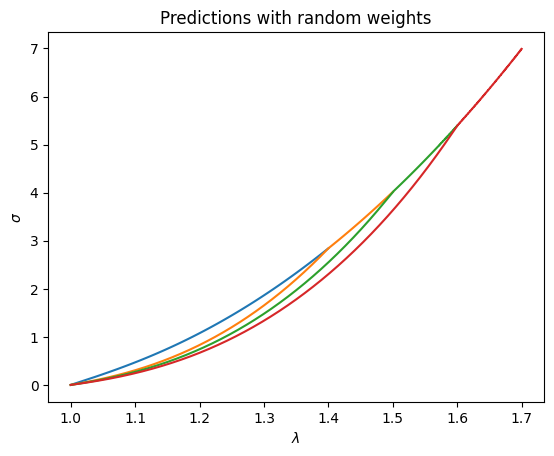

In [8]:
for i in range(4):
    i1 = i*n_per_test
    i2 = (i+1)*n_per_test
    plt.plot(lmbx[i1:i2], sgm[i1:i2, 0, 0])
plt.xlabel('$\lambda$')
plt.ylabel('$\sigma$')
plt.title('Predictions with random weights')

# Set up training

In [9]:
def get_damage_stress(params, inp):
    params_Psi_list = params[0]
    r_init = params[-1]
    lmbx, lmby, times = inp
    dts = jnp.diff(times)
    
    lmbz = 1.0/jnp.sqrt(lmbx*lmby)
    I1 = lmbx**2 + lmby**2 + lmbz**2
    I2 = lmbx**2*lmby**2 + lmbx**2*lmbz**2 + lmby**2*lmbz**2
    theta_v = params_Psi_list[2][1]
    Iv = lmbx**2*jnp.sin(theta_v)**2 + lmby**2*jnp.cos(theta_v)**2
    theta_w = params_Psi_list[3][1]
    Iw = lmbx**2*jnp.sin(theta_w)**2 + lmby**2*jnp.cos(theta_w)**2

    I_vec = jnp.array([I1[1:], I2[1:], Iv[1:], Iw[1:]]).T
    I_prev_vec = jnp.array([I1[:-1], I2[:-1], Iv[:-1], Iw[:-1]]).T
    xs = jnp.hstack([I_vec, I_prev_vec, dts[:,None]])
    
    init = [0.0,0.0,0.0,0.0] + r_init
    d = update_hist(params, init, xs)
    sgmx_pr = eval_Cauchy_vmap(lmbx, lmby, d, params)
    return sgmx_pr, d

def loss(params, inp, sgmx_gt):
    sgmx_pr = get_damage_stress(params, inp[:3])[0]
    include_in_training = inp[-1]
    return jnp.mean((sgmx_gt-sgmx_pr[:,0,0])**2*include_in_training)

def loss_nodamage(params, inp, sgmx_gt):
    lmbx, lmby, _, _ = inp
    d = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
    sgmx_pr = eval_Cauchy_vmap2(lmbx, lmby, d, params)
    return jnp.mean((sgmx_gt-sgmx_pr[:,0,0])**2)

@partial(jit, static_argnums=(0,2,3,))
def step(loss, i, get_params, opt_update, opt_state, X_batch, Y_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch, Y_batch)
    return opt_update(i, g, opt_state)

def train(loss, X, Y, get_params, opt_update, opt_state, key, nIter = 10000, print_freq=1000, metric_fns=None, batch_size=None):
    train_loss = []
    metrics = []
    for it in range(nIter):
        key, subkey = random.split(key)
        if batch_size is None:
            X_batch = X
            Y_batch = Y
        else:
            idx = random.choice(key=key, a=jnp.arange(len(X)), shape=(batch_size,), replace=False)
            X_batch = X[idx]
            Y_batch = Y[idx]
        opt_state = step(loss, it, get_params, opt_update, opt_state, X_batch, Y_batch)         
        if (it+1)% print_freq == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            if metric_fns is not None:
                m = []
                for metric_fn in metric_fns:
                    m.append(metric_fn(params, X, Y))
                metrics.append(m)
            to_print = "it %i, train loss = %e" % (it+1, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, metrics

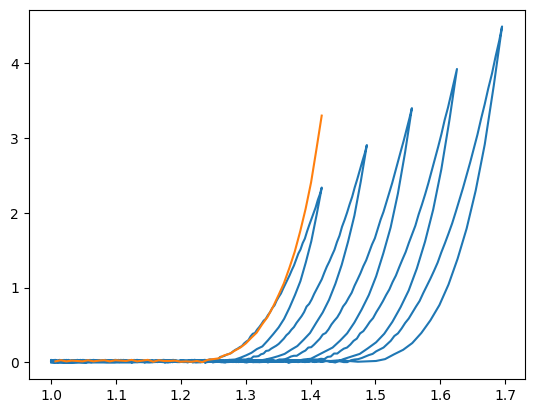

In [110]:
data = pd.read_csv('data/Dermis/DamageData/PA_Belly_Dermis1Data.csv')
def extract_numbers_and_cycle(value):
    parts = value.split('-')
    number = int(parts[0])
    cycle = parts[1] if len(parts) > 1 else None
    return pd.Series({'#': number, 'Cycle': cycle})

# Apply the custom function to the 'Cycle' column
data[['#', 'Cycle']] = data['Cycle'].apply(extract_numbers_and_cycle) #Separate the 'Cycle' column into two columns
data = data[['SetName', '#', 'Cycle', 'Time_S', 'Size_mm', 'Displacement_mm', 'Force_N']] #Reorder the columns
data = data.rename(columns={'Cycle': 'Type', '#': 'Cycle'})
size = data['Size_mm'][0]
data_nodamage = data[(data.SetName=='Stretch3')&(data.Cycle==1)&(data.Type=='Recover')]
time_nd = data_nodamage['Time_S'].to_numpy()
time_nd = time_nd - np.min(time_nd)
size_nd = data_nodamage['Size_mm'].to_numpy()
disp_nd = data_nodamage['Displacement_mm'].to_numpy()
lmbx_nd = 1.0+disp_nd/size
lmby_nd = 1.0/np.sqrt(lmbx_nd)
sgmx_nd = data_nodamage['Force_N'].to_numpy()/20.0
load_nd = np.ones_like(sgmx_nd)

#Only keep the last cycle for each set
data = data[data.Cycle==5]
load_gt = np.array(data.Type=="Recover", dtype='float') #Contains 1s for unloading and 0s for loading
time_gt = data['Time_S'].to_numpy() 
time_gt = time_gt - np.min(time_gt)
size_gt = data['Size_mm'].to_numpy()
disp_gt = data['Displacement_mm'].to_numpy()
lmbx_gt = 1.0+disp_gt/size
lmby_gt = 1.0/np.sqrt(lmbx_gt)
sgmx_gt = data['Force_N'].to_numpy()/20.0

plt.plot(lmbx_gt, sgmx_gt)
plt.plot(lmbx_nd, sgmx_nd)

In [111]:
jump_pts = 1+np.where(np.diff(time_gt)>5)[0]
jump_pts = np.append(jump_pts, len(time_gt))

i1 = jump_pts[0]
for i in range(1,len(jump_pts)):
    i2 = jump_pts[i]
    time_gt[i1:i2] = time_gt[i1:i2] - time_gt[i1] + time_gt[i1-1] + 0.2
    i1 = i2

In [112]:
#Train with no damage first
params = init_params_damage(key)
opt_init, opt_update, get_params = optimizers.adam(1.e-3) #Original: 1.e-4
opt_state = opt_init(params)

inp = np.vstack([lmbx_nd, lmby_nd, time_nd, load_nd])
out = sgmx_nd
params, train_loss, _ = train(loss_nodamage, inp, out, get_params, opt_update, opt_state, key, nIter = 40000, print_freq=1000)

it 1000, train loss = 1.868621e-01
it 2000, train loss = 1.262791e-01
it 3000, train loss = 6.447505e-02
it 4000, train loss = 3.897194e-02
it 5000, train loss = 2.615776e-02
it 6000, train loss = 1.149988e-02
it 7000, train loss = 1.878337e-03
it 8000, train loss = 9.216825e-04
it 9000, train loss = 5.670381e-04
it 10000, train loss = 3.906574e-04
it 11000, train loss = 3.344240e-04
it 12000, train loss = 3.048634e-04
it 13000, train loss = 2.858014e-04
it 14000, train loss = 2.711594e-04
it 15000, train loss = 2.610406e-04
it 16000, train loss = 2.549499e-04
it 17000, train loss = 2.497424e-04
it 18000, train loss = 2.474906e-04
it 19000, train loss = 2.458315e-04
it 20000, train loss = 2.454607e-04
it 21000, train loss = 2.418041e-04
it 22000, train loss = 2.388462e-04
it 23000, train loss = 2.348103e-04
it 24000, train loss = 2.291325e-04
it 25000, train loss = 2.213484e-04
it 26000, train loss = 2.084735e-04
it 27000, train loss = 1.902368e-04
it 28000, train loss = 1.713061e-04
i

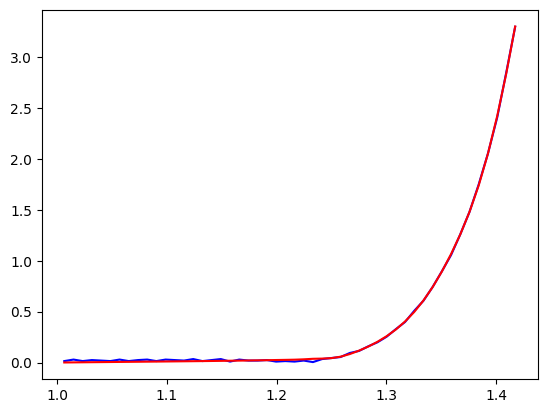

In [113]:
d = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
sgmx_pr = eval_Cauchy_vmap2(lmbx_nd, lmby_nd, d, params)
sgmx_pr = sgmx_pr[:,0,0]

plt.plot(lmbx_nd, sgmx_nd, 'b-')
plt.plot(lmbx_nd, sgmx_pr, 'r-')

In [114]:
time_tr = np.linspace(np.min(time_gt), np.max(time_gt), 10000)
lmbx_tr = np.interp(time_tr, time_gt, lmbx_gt)
lmby_tr = np.interp(time_tr, time_gt, lmby_gt)
sgmx_tr = np.interp(time_tr, time_gt, sgmx_gt)
load_tr = np.interp(time_tr, time_gt, load_gt)

In [ ]:
#Train just the damage parameters
def loss_nohyper(damage_params, inp, sgmx_gt):
    p = [params[0], damage_params[1], damage_params[2], damage_params[3]]
    return loss(p, inp, sgmx_gt)
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(params)

# Train
inp = np.vstack([lmbx_tr, lmby_tr, time_tr, load_tr])
out = sgmx_tr
params, train_loss, _ = train(loss_nohyper, inp, out, get_params, opt_update, opt_state, key, nIter = 1000, print_freq=100)

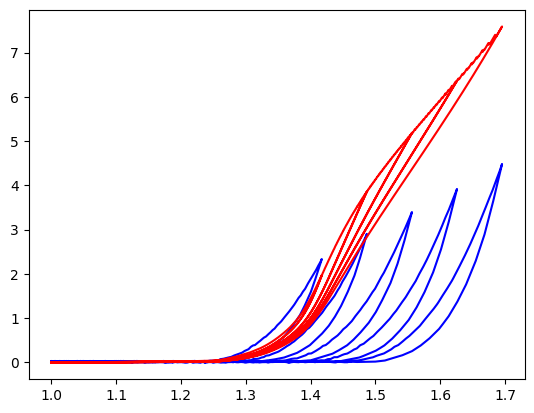

In [116]:
sgmx_pr, d = get_damage_stress(params, inp[:3])
sgmx_pr = sgmx_pr[:,0,0]

plt.plot(lmbx_tr, sgmx_tr, 'b-')
plt.plot(lmbx_tr, sgmx_pr, 'r-')

In [119]:
# params = init_params_damage(key)
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(params)

# Train everything together
inp = np.vstack([lmbx_tr, lmby_tr, time_tr, load_tr])
out = sgmx_tr
params, train_loss, _ = train(loss, inp, out, get_params, opt_update, opt_state, key, nIter = 5000, print_freq=500)

it 500, train loss = 4.221354e-02
it 1000, train loss = 4.048880e-02
it 1500, train loss = 3.908756e-02
it 2000, train loss = 4.041361e-02
it 2500, train loss = 4.020018e-02
it 3000, train loss = 4.012265e-02
it 3500, train loss = 4.001772e-02
it 4000, train loss = 3.994638e-02
it 4500, train loss = 3.989359e-02
it 5000, train loss = 3.986209e-02


loss =  0.039862091716185086


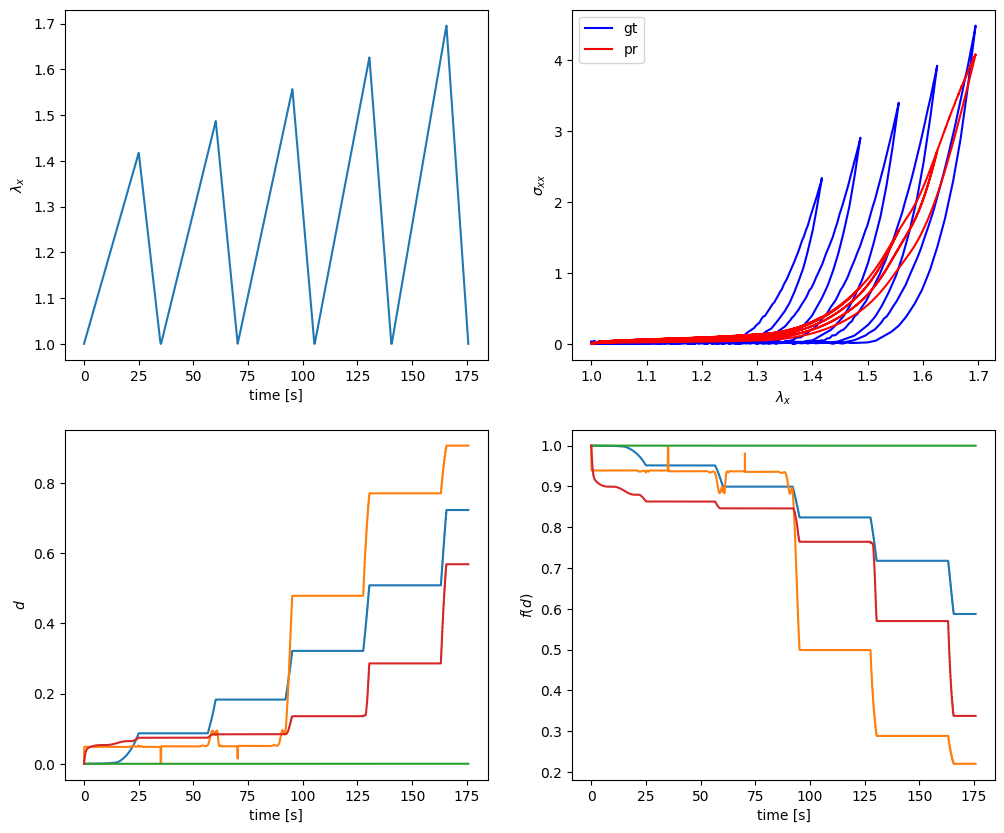

In [120]:
fig, ax = plt.subplots(2,2,figsize=(12,10))
f_params = params[1]
sgmx_pr, d = get_damage_stress(params, inp[:3])
sgmx_pr = sgmx_pr[:,0,0]

ax[0,0].plot(time_tr, lmbx_tr)
ax[0,0].set(xlabel='time [s]', ylabel = '$\lambda_x$')

ax[0,1].plot(lmbx_tr, sgmx_tr, 'b-', label='gt')
ax[0,1].plot(lmbx_tr, sgmx_pr, 'r-', label='pr')
ax[0,1].legend()
ax[0,1].set(xlabel='$\lambda_x$', ylabel='$\sigma_{xx}$')

for i in range(len(d.T)):
    ax[1,0].plot(time_tr, d[:,i])
    ax[1,1].plot(time_tr, f_vmap(d[:,i], f_params[i]))
ax[1,0].set(xlabel='time [s]', ylabel='$d$')
ax[1,1].set(xlabel='time [s]', ylabel='$f(d)$')

l = loss(params, inp, sgmx_tr)
print('loss = ', l)

loss =  0.03828330050717932


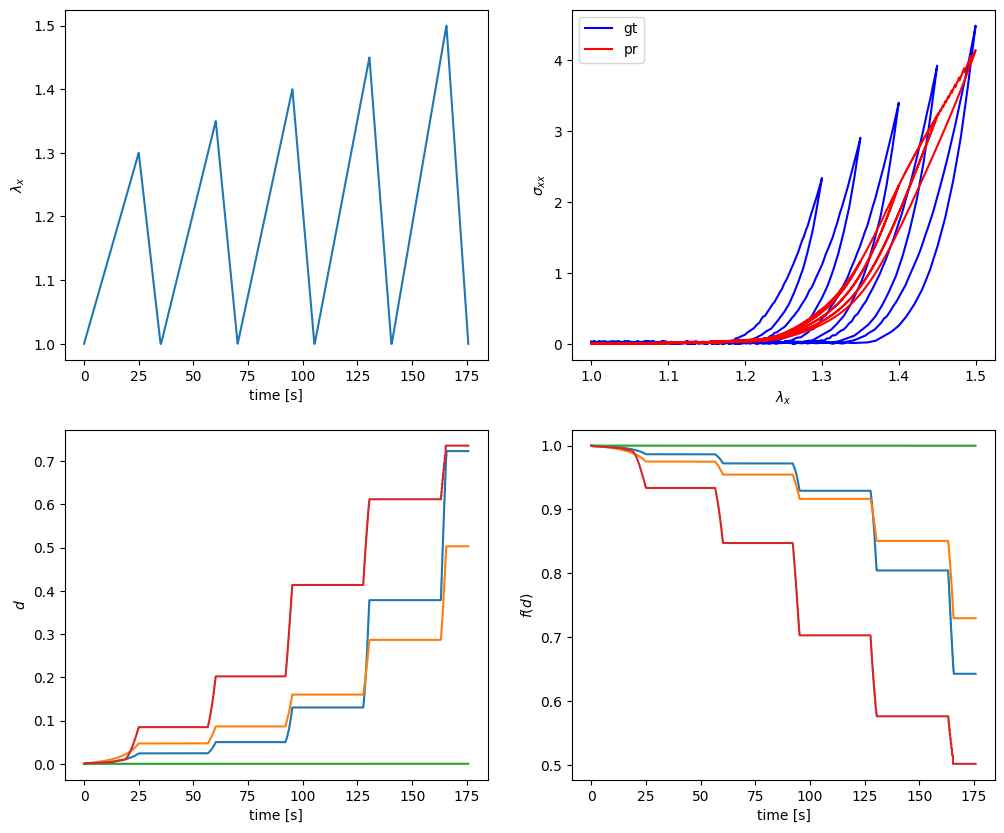

In [37]:
fig, ax = plt.subplots(2,2,figsize=(12,10))
f_params = params[1]
sgmx_pr, d = get_damage_stress(params, inp[:3])
sgmx_pr = eval_Cauchy_vmap(lmbx_tr, lmby_tr, 0.8*d, params)
sgmx_pr = sgmx_pr[:,0,0]

ax[0,0].plot(time_tr, lmbx_tr)
ax[0,0].set(xlabel='time [s]', ylabel = '$\lambda_x$')

ax[0,1].plot(lmbx_tr, sgmx_tr, 'b-', label='gt')
ax[0,1].plot(lmbx_tr, sgmx_pr, 'r-', label='pr')
ax[0,1].legend()
ax[0,1].set(xlabel='$\lambda_x$', ylabel='$\sigma_{xx}$')

for i in range(len(d.T)):
    ax[1,0].plot(time_tr, d[:,i])
    ax[1,1].plot(time_tr, f_vmap(d[:,i], f_params[i]))
ax[1,0].set(xlabel='time [s]', ylabel='$d$')
ax[1,1].set(xlabel='time [s]', ylabel='$f(d)$')

l = loss(params, inp, sgmx_tr)
print('loss = ', l)

In [21]:
with open('params/weights.npy', 'wb') as file:
    pickle.dump(params, file)

loss =  69.57719316738496


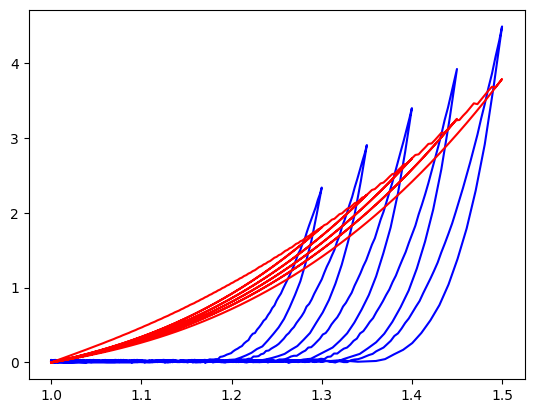

In [12]:
inp = np.vstack([lmbx_gt, lmby_gt, time_gt, load_gt])
sgmx_pr, d = get_damage_stress(params, inp[:3])
sgmx_pr = sgmx_pr[:,0,0]

plt.plot(lmbx_gt, sgmx_gt, 'b-')
plt.plot(lmbx_gt, sgmx_pr, 'r-')

l = loss(params, inp, sgmx_gt)
print('loss = ', l)

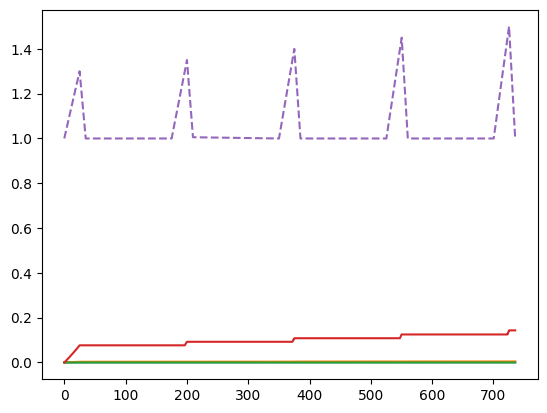

In [14]:
plt.plot(time_gt, d[:,0])
plt.plot(time_gt, d[:,1])
plt.plot(time_gt, d[:,2])
plt.plot(time_gt, d[:,3])
plt.plot(time_gt, lmbx_gt, '--')

In [25]:
params_Psi_list, params_f_list, params_G_list = params
f0 = f_vmap(d[:,0], params_f_list[0])
f1 = f_vmap(d[:,1], params_f_list[1])
f2 = f_vmap(d[:,2], params_f_list[2])
f3 = f_vmap(d[:,3], params_f_list[3])

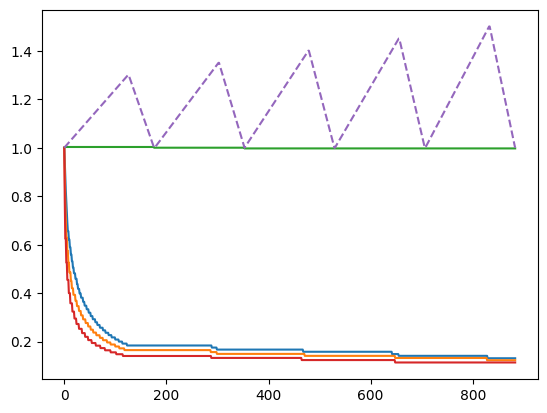

In [26]:
plt.plot(f0)
plt.plot(f1)
plt.plot(f2)
plt.plot(f3)
plt.plot(lmbx_gt, '--')

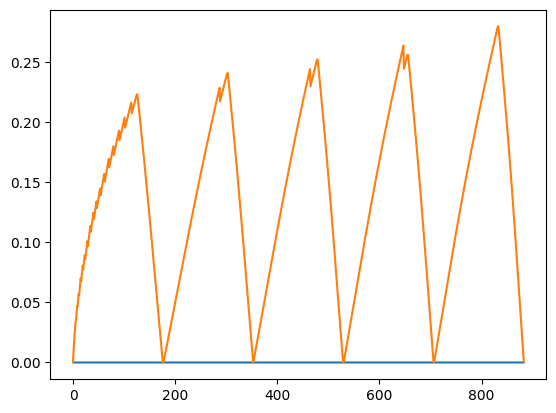

In [27]:
lmbx = lmbx_gt
lmby = lmby_gt
lmbz = 1.0/jnp.sqrt(lmbx*lmby)
I1 = lmbx**2 + lmby**2 + lmbz**2
I2 = lmbx**2*lmby**2 + lmbx**2*lmbz**2 + lmby**2*lmbz**2
theta_v = params_Psi_list[2][1]
Iv = lmbx**2*jnp.sin(theta_v)**2 + lmby**2*jnp.cos(theta_v)**2
theta_w = params_Psi_list[3][1]
Iw = lmbx**2*jnp.sin(theta_w)**2 + lmby**2*jnp.cos(theta_w)**2

params_1, params_2, params_v, params_w = params_Psi_list
Psi1 = f0*vmap(Psi1_fn, in_axes=(None,0))(params_1, I1)
Psi2 = f1*vmap(Psi2_fn, in_axes=(None,0))(params_2, I2)
Psiv = f2*vmap(Psiv_fn, in_axes=(None,0))(params_v, Iv)
Psiw = f3*vmap(Psiw_fn, in_axes=(None,0))(params_w, Iw)

# plt.plot(Psi1)
# plt.plot(Psi2)
plt.plot(Psiv)
plt.plot(Psiw)

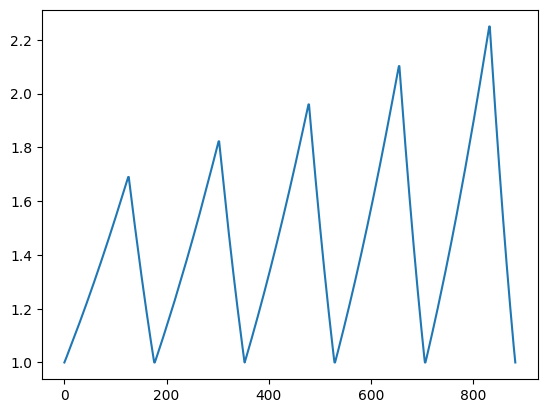

In [21]:
plt.plot(Iw)